## K-Armed bandit

You are given a option to choose out of say k options, like lever on a slot machine. Pulling each lever, you get some reward (which can be random with some distribution, for each action). The question is how to maximize our reward over some time steps.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
import math
import random

In [2]:
K = 10
TIME_STEP = 1000
NUMBER_RUN = 2000
SEED=38
random.seed(SEED)
LINEWIDTH = 1
FIGSIZE = (12, 8)

### 1. Define K Armed Bandit class

In [6]:
class KArmedBandit():
    def __init__(self, k=K, random_dist=False):
        self.k = k
        self.pdfs = []
        if random_dist:
            for _ in range(self.k):
                mu = random.uniform(-3, 3)  # Mean
                sigma = 1  # Standard deviation
                def normal_dist(mu=mu, sigma=sigma):  # require func params, else some weird quirk of function referencing same variable
                    return random.gauss(mu, sigma)
                self.pdfs.append([normal_dist, mu, sigma])  # to sample call it as a func: normal_dist()     
        else:
            mu = [0.4, -0.9, 1.5, 0.6, 1.4, -1.5, 0.2, -1.1, 0.9, -0.5]
            sigma = 1
            for i in range(self.k):
                def normal_dist(mu=mu[i], sigma=sigma):
                    return random.gauss(mu, sigma)
                self.pdfs.append([normal_dist, mu[i], sigma])  # to sample call it as a func: normal_dist()                       
 
    def get_reward(self, a):
        # action (a) \in [0, 1, ... , k-1]
        reward = self.pdfs[a][0]()
        return reward

    def get_optimal_action(self):
        # mean_lst = [pdf[1] for pdf in self.pdfs]
        # max_mean = max(mean_lst)
        # max_indices = [i for i, value in enumerate(mean_lst) if value == max_mean]
        # return int(random.choice(max_indices))
        return int(np.argmax([pdf[1] for pdf in self.pdfs]))  # ensure 1 optimal action

    def visualize(self):
        # Number of samples to draw from each distribution
        num_samples = 1000

        # Create a list to store the data
        data = []

        # Sample rewards for each action
        for action in range(self.k):
            samples = [self.pdfs[action][0]() for _ in range(num_samples)]
            data.extend([(sample, action) for sample in samples])

        # Convert data to a DataFrame
        df = pd.DataFrame(data, columns=['Reward', 'Action'])

        # Create the violin plot
        plt.figure(figsize=(10, 6))
        sns.violinplot(x='Action', y='Reward', data=df, inner='quartile')

        plt.title('Violin Plot of Rewards for Each Action')
        plt.xlabel('Action')
        plt.ylabel('Reward')
        plt.grid(True)
        plt.show()


In [7]:
# k_armed_bandit = KArmedBandit(k=K, random_dist=False)

In [8]:
# k_armed_bandit.visualize()

In [9]:
# type(k_armed_bandit.get_optimal_action())

### 2. Implement various Strategies

In [10]:
class Store():
    def __init__(self, names=["Generic Strategy"], num_run=NUMBER_RUN, time_step=TIME_STEP):
        self.names = names
        self.num_run = num_run
        self.time_step = time_step
        self.history = {}  # history[name][i][j] = ith run and jth time step = [reward, action]
        for name in names:
            history_name_strategy = [[[0, 0] for _ in range(self.time_step)] for _ in range(self.num_run)]
            self.history.update({name: history_name_strategy})
        self.mean = {}
        self.choose_optimal_action = {}  # % optimal action choosen
        for name in names:
            mean_name_strategy = [-10]*self.time_step
            self.mean.update({name: mean_name_strategy})
        for name in names:
            name_choose_optimal_action = [0]*self.time_step
            self.choose_optimal_action.update({name: name_choose_optimal_action})

    def update_store(self, name_strategy, i, j, reward, action):
        # i being the run number and j being time step
        self.history[name_strategy][i][j] = [reward, action]
        
    def calculate_mean_per_time_step(self):
        for name in self.names:
            for i in range(self.time_step):
                self.mean[name][i] = sum(row[i][0] for row in self.history[name]) / self.num_run

    def calculate_percentage_optimal_choice(self, optimal_action):
        for name in self.names:
            for i in range(self.time_step):
                self.choose_optimal_action[name][i] = sum((row[i][1]==optimal_action) for row in self.history[name]) / self.num_run * 100
    
    def visualize_mean(self, name, linestyle='-', color='b'):
        x = list(range(self.time_step))
        plt.plot(x, self.mean[name], linestyle=linestyle, color=color, \
                 linewidth=LINEWIDTH, label=name)
        plt.xlabel('Time Step')
        plt.ylabel('Mean reward')
        plt.title(f'Expected mean per time step for: {name}')
        plt.legend()
        plt.grid(True)
        plt.show()

    def combine_visualize_mean(self):
        plt.figure(figsize=FIGSIZE)

        # Define a list of colors
        colors = plt.get_cmap('Set1').colors  # Use a colormap to get a list of colors
    
        for i, (name, data) in enumerate(self.mean.items()):
            x = range(self.time_step)
            plt.plot(x, data, color=colors[i % len(colors)], linestyle='-', linewidth=LINEWIDTH, label=name)
    
        plt.xlabel('Time Step')
        plt.ylabel('Reward')
        plt.title('Avg reward for Each Strategy')
        plt.legend()
        plt.grid(True)
        plt.show()

    def visualize_action(self, name, linestyle='-', color='b'):
        x = list(range(self.time_step))
        plt.plot(x, self.choose_optimal_action[name], linestyle=linestyle, color=color, \
                 linewidth=LINEWIDTH, label=name)
        plt.xlabel('Time Step')
        plt.ylabel('% Optimal Action')
        plt.title(f'% Optimal Action choose by : {name}')
        plt.legend()
        plt.grid(True)
        plt.show()

    def combine_optimal_choice(self):
        plt.figure(figsize=FIGSIZE)

        # Define a list of colors
        colors = plt.get_cmap('Set1').colors  # Use a colormap to get a list of colors
    
        for i, (name, data) in enumerate(self.choose_optimal_action.items()):
            x = range(self.time_step)
            plt.plot(x, data, color=colors[i % len(colors)], linestyle='-', linewidth=LINEWIDTH, label=name)
    
        plt.xlabel('Time Step')
        plt.ylabel('% Optimal Action')
        plt.title('% Optimal Action choose by each Strategy')
        plt.legend()
        plt.grid(True)
        plt.show()

In [11]:
# store = Store(["a", "b"], num_run=2, time_step=2)
# store.update_store("a", 0, 0, 1, 0)
# store.update_store("a", 0, 1, 2, 0)
# store.update_store("a", 1, 0, 2, 1)
# store.update_store("a", 1, 1, 2, 0)

# store.update_store("b", 0, 0, 2, 0)
# store.update_store("b", 0, 1, 2, 1)
# store.update_store("b", 1, 0, 1, 0)
# store.update_store("b", 1, 1, 2, 1)

# store.calculate_mean_per_time_step()
# store.calculate_percentage_optimal_choice(0)

# store.visualize_mean("a")
# store.visualize_mean("b")
# store.visualize_action("a")
# store.visualize_action("b")
# store.combine_visualize_mean()
# store.combine_optimal_choice()

In [12]:
# An interface for all the strategies for picking optimal action
class Strategy():
    def __init__(self, k=K):
        self.name = "Generic Strategy"
        self.k = k
        pass
    def get_action(self):
        # returns action [0, 1, ..., k-1]
        pass
    def update_strategy(self, cur_action, cur_reward):
        # update the strategy based on reward in accordance with action you just took
        pass
    def reset(self):
        # resets strategy state to original
        pass

In [13]:
class RandomAction(Strategy):
    def __init__(self, k=K, name=""):
        self.name = f"RandomAction {name}"
        self.k = k 
        
    def get_action(self):
        return int(random.choice(range(self.k)))  # pick one at random  
        
    def update_strategy(self, cur_action, cur_reward):
        pass
        
    def reset(self):
        pass

In [14]:
class GreedyStrategy(Strategy):
    def __init__(self, k=K, optimistic_initial_guess_reward=True):
        self.name = f"Greedy with optimism {optimistic_initial_guess_reward}"
        self.k = K
        self.n = [0]*self.k  # number of attempts made
        self.optimistic_initial_guess_reward = optimistic_initial_guess_reward
        if self.optimistic_initial_guess_reward:
            self.avg_rewards = [1000]*self.k
        else:
            self.avg_rewards = [0]*self.k
            
    def get_action(self):
        max_value = max(self.avg_rewards)
        max_indices = [i for i, value in enumerate(self.avg_rewards) if value == max_value]
        return int(random.choice(max_indices))
        # return int(np.argmax(self.avg_rewards))
        
    def update_strategy(self, cur_action, cur_reward):
        self.n[cur_action] += 1
        alpha = 1/self.n[cur_action]  # after updating n -> n + 1!
        self.avg_rewards[cur_action] = self.avg_rewards[cur_action] + alpha * (cur_reward \
                                                                               - self.avg_rewards[cur_action])
    def reset(self):
        self.n = [0]*self.k
        if self.optimistic_initial_guess_reward:
            self.avg_rewards = [1000]*self.k
        else:
            self.avg_rewards = [0]*self.k

In [15]:
class EpsilonGreedyStrategy(Strategy):
    def __init__(self, k=K, epsilon=0.1, optimistic_initial_guess_reward=True):
        self.name = f"epsilon-{epsilon} Greedy Policy with optimism {optimistic_initial_guess_reward}"
        self.epsilon = epsilon
        self.k = K
        self.n = [0]*self.k  # number of attempts made
        self.optimistic_initial_guess_reward = optimistic_initial_guess_reward
        if self.optimistic_initial_guess_reward:
            self.avg_rewards = [5]*self.k
        else:
            self.avg_rewards = [0]*self.k
            
    def get_action(self):
        u = random.uniform(0,1)
        if u > self.epsilon:  # P(greedy action) = P(u > epsilon) = 1-epsilon
            max_value = max(self.avg_rewards)
            max_indices = [i for i, value in enumerate(self.avg_rewards) if value == max_value]
            return int(random.choice(max_indices))
            # return int(np.argmax(self.avg_rewards))
        else:  # P(random action) = epsilon
            return int(random.choice(range(self.k)))  # pick one at random  
        
    def update_strategy(self, cur_action, cur_reward):
        self.n[cur_action] += 1
        alpha = 1/self.n[cur_action]  # after updating n -> n + 1
        self.avg_rewards[cur_action] = self.avg_rewards[cur_action] + alpha * (cur_reward \
                                                                               - self.avg_rewards[cur_action])
    def reset(self):
        self.n = [0]*self.k
        if self.optimistic_initial_guess_reward:
            self.avg_rewards = [5]*self.k
        else:
            self.avg_rewards = [0]*self.k

In [16]:
class PolicyGradient(Strategy):
    def __init__(self, k=K, alpha=0.1):
        self.name = f"Policy Gradient with alpha={alpha}"
        self.k = k
        self.preference_lst = [0]*self.k
        self.alpha = alpha
        self.baseline_lst = [0]*self.k  # running average for that state
        self.n = [0]*self.k  # number of attempts made

    def preference_to_probability(self):
        # probability of picking that actions (of selecting ath machine)
        sum_prob = sum([math.exp(preference) for preference in self.preference_lst])
        prob_lst = [math.exp(preference)/sum_prob for preference in self.preference_lst]
        return prob_lst
        
    def get_action(self):
        prob_lst = self.preference_to_probability()
        actions = list(range(self.k))
        return int(random.choices(actions, weights=prob_lst, k=1)[0])

    def update_strategy(self, cur_action, cur_reward):
        prob_lst = self.preference_to_probability()
        # update preference
        for a in range(self.k):  # sampling over actions
            if a == cur_action:
                self.preference_lst[a] = self.preference_lst[a] + \
                                        self.alpha * (cur_reward - self.baseline_lst[a]) * (1-prob_lst[a])
            else:
                self.preference_lst[a] = self.preference_lst[a] - \
                                        self.alpha * (cur_reward - self.baseline_lst[a]) * prob_lst[a]
        # update baseline
        self.n[cur_action] += 1
        lr = 1/self.n[cur_action]  # after updating n -> n + 1
        self.baseline_lst[cur_action] = self.baseline_lst[cur_action] + lr * (cur_reward \
                                                                              - self.baseline_lst[cur_action])

    def reset(self):
        self.preference_lst = [0]*self.k
        self.baseline_lst = [0]*self.k
        self.n = [0]*self.k

In [43]:
# upper confidence bound algorithm
class UCBStrategy(Strategy):
    def __init__(self, k, alpha):
        self.k = k
        self.name = "Upper Confidence Bound (UCB)"
        self.alpha = alpha  # Exploration parameter
        self.counts = np.zeros(k, dtype=int)  # Number of times each action was selected
        self.avg_rewards = np.zeros(k, dtype=float)  # Estimated reward values

    def get_action(self):
        total_counts = np.sum(self.counts)  # equivalently this is the current time
        
        if total_counts < self.k:  
            # Play each action at least once (sequentially till all have one)
            return total_counts
        
        # Calculate UCB values
        ucb_values = self.avg_rewards + self.alpha * np.sqrt(np.log(total_counts) / (self.counts + 1e-5))
        return np.argmax(ucb_values)

    def update_strategy(self, cur_action, cur_reward):
        self.counts[cur_action] += 1
        n = self.counts[cur_action]
        self.avg_rewards[cur_action] += (cur_reward - self.avg_rewards[cur_action]) / n  # Incremental mean update

    def reset(self):
        self.counts.fill(0)
        self.avg_rewards.fill(0)

### 3. Experimentation and Comparing various strategies

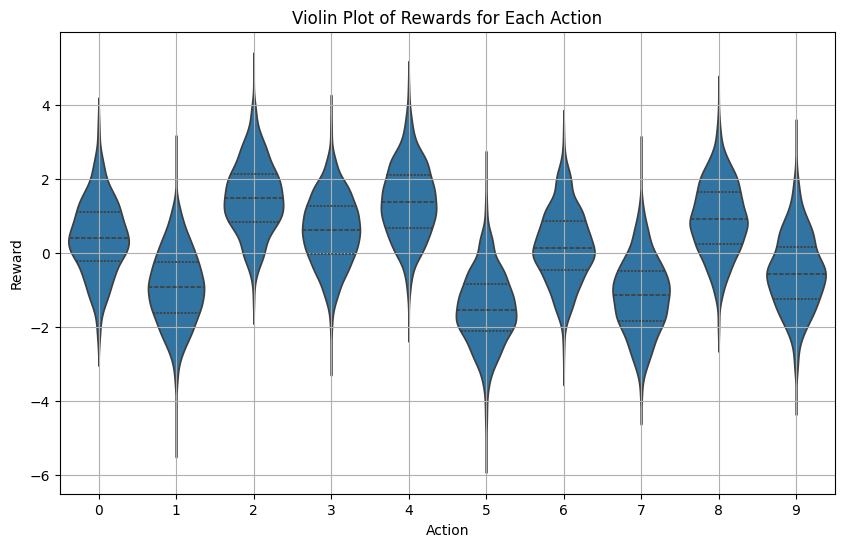

Upper Confidence Bound (UCB): 100%|████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:19<00:00, 102.82 #Run/s]


In [44]:
strategies = [GreedyStrategy(k=K,optimistic_initial_guess_reward=True), \
              EpsilonGreedyStrategy(k=K, epsilon=0.1, optimistic_initial_guess_reward=False), \
              PolicyGradient(k=K, alpha=0.03), \
              UCBStrategy(k=K, alpha=3) \
             ]  # list of lambda functions for each Strategies
strategies_names = [strategy.name for strategy in strategies]
store = Store(strategies_names, num_run=NUMBER_RUN, time_step=TIME_STEP)
k_armed_bandit = KArmedBandit(k=K, random_dist=False)  # define a new experiment
k_armed_bandit.visualize()

for strategy in strategies:
    for run in tqdm(range(NUMBER_RUN), desc=f"{strategy.name}", unit=" #Run"):
        strategy.reset()
        for i in range(TIME_STEP):
            action = strategy.get_action()
            reward = k_armed_bandit.get_reward(action)
            strategy.update_strategy(action, reward)
            store.update_store(strategy.name, run, i, reward, action)

store.calculate_mean_per_time_step()
store.calculate_percentage_optimal_choice(k_armed_bandit.get_optimal_action())

In [45]:
# store.visualize_mean(strategies_names[0])
# store.visualize_action(strategies_names[0])

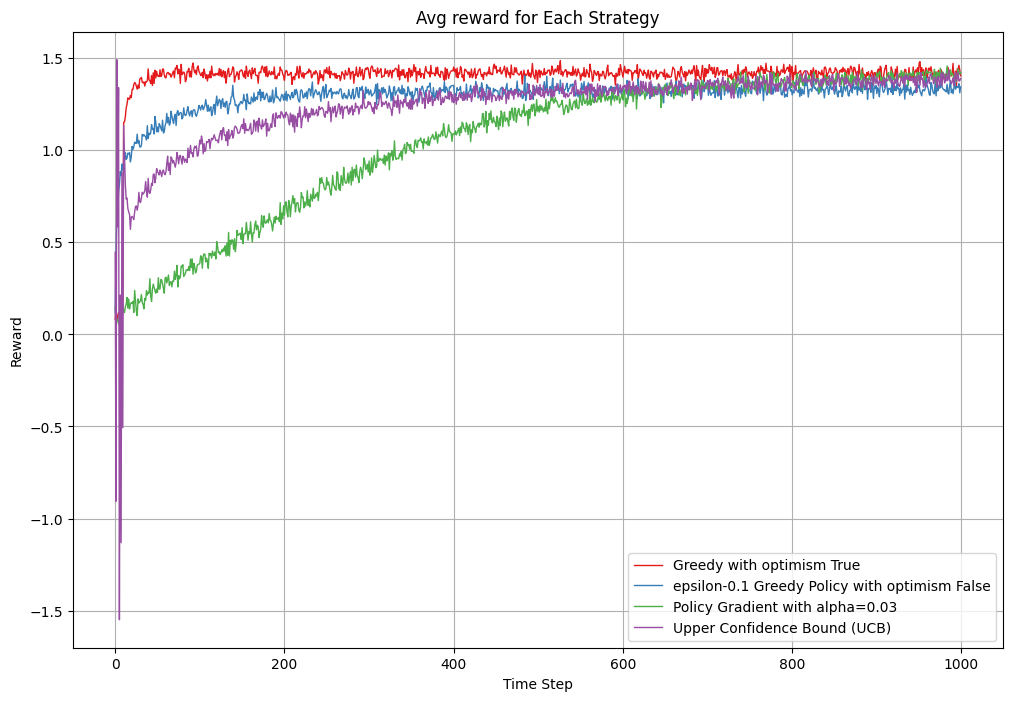

In [46]:
store.combine_visualize_mean()

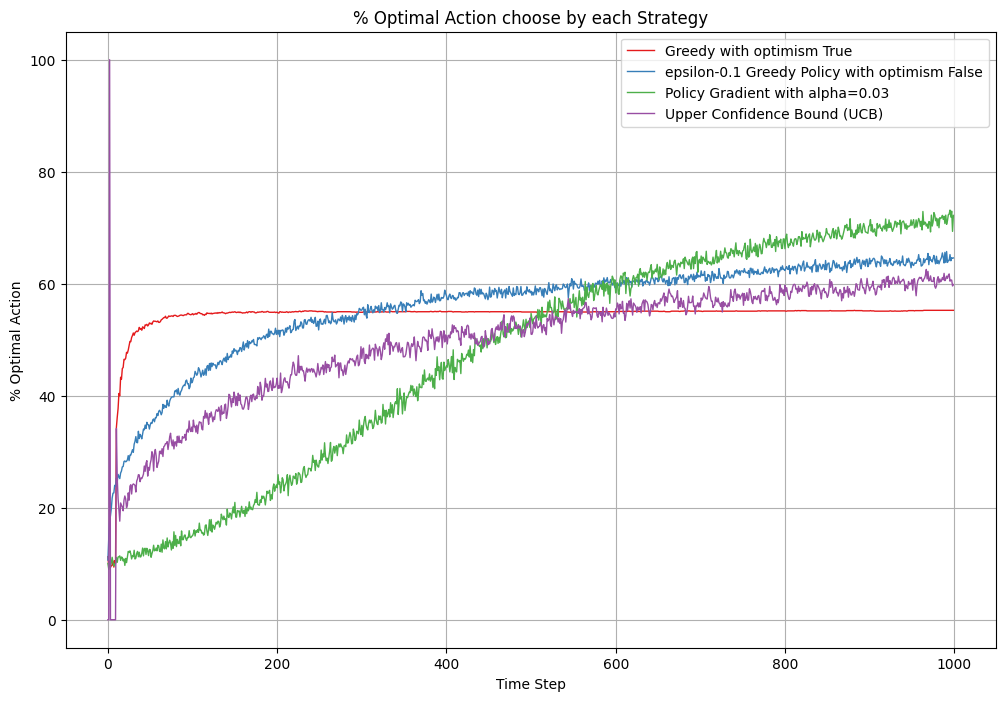

In [47]:
store.combine_optimal_choice()